# Setup
## Imports

In [22]:
# general packages
import os
from os import environ
from os.path import join

import re
import glob
import json
from io import StringIO

import matplotlib.pyplot as plt

import requests

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

## Functions definition

In [3]:
# Functions
def download_dahiti_data(dahiti_id, file_format, api_key):
    """Download data for a given dahiti_id lake

    Args:
        dahiti_id (int): The DAHITI ID of the desired lake
        file_format (str): can be either 'json', 'ascii', 'netcdf' or 'csv'
        api_key (str): The API key to connect to the DAHITI API

    Returns:
        str|dict(str)|bytes: The data to write to a file
    """
    url = "https://dahiti.dgfi.tum.de/api/v2/download-water-level/"

    args = {}
    args['api_key'] = api_key
    args['dahiti_id'] = dahiti_id
    args['format'] = file_format

    response = requests.get(url,params=args)

    if response.status_code == 200:
        if args['format'] == "ascii":
            data = response.text
        if args['format'] == "json":
            data = json.loads(response.text)
        if args['format'] == "netcdf":
            data = response.content
        if args['format'] == "csv":
            data = response.text
    else:
        print (response.text)
        print (response.status_code)
        
    return data

def extract_coordinates(text):
    """Extract longitude and latitude from text with format like '-106.45 °W, 36.25 °N'"""
    pattern = r'(-?\d+\.?\d*)\s*°W,\s*(-?\d+\.?\d*)\s*°N'
    match = re.search(pattern, text)
    
    if match:
        lon_val = float(match.group(1))
        lat_val = float(match.group(2))
        
        # Convert to CRS 4326 (WGS84) decimal degrees
        longitude = -abs(lon_val)  # West is negative
        latitude = lat_val         # North is positive
        
        return longitude, latitude
    return None, None

## Parameters

In [17]:
# main path
data_folder = '../data'

# Paths
dahiti_path = join(data_folder, 'dahiti')
aoi_path = join(data_folder, 'admin', 'adm2.geojson')

# Main code

## Download available files
Inspired from a script from https://dahiti.dgfi.tum.de/en/api/doc/v2/download-water-level/

List of data available in Iraq: https://dahiti.dgfi.tum.de/en/virtual-stations/asia/

In [5]:
aoi_gdf = gpd.read_file(aoi_path)
datasets_df = pd.read_html("https://dahiti.dgfi.tum.de/en/virtual-stations/north_america/united_states_of_america/")[0]

datasets_df.head()

,ID,Target Name,Available Dataset(s)
0,39392,"Abiquiu, Reservoir -106.45 °W, 36.25 °N",Water Level Surface Area Water Occurrence Mas...
1,17850,"Alabama, River -87.74 °W, 31.33 °N",Water Level Discharge
2,20164,"Alabama, River -87.44 °W, 31.92 °N",Water Level Discharge
3,20165,"Alabama, River -86.49 °W, 32.36 °N",Water Level Discharge
4,13147,"Alan Henry, Lake -101.09 °W, 33.05 °N",Water Level Surface Area Water Occurrence Ma...


In [ ]:
# Extract coordinates into a temporary series
coords = datasets_df['Target Name'].apply(extract_coordinates)

# Split into separate columns
datasets_df['Longitude'] = coords.apply(lambda x: x[0] if x[0] is not None else None)
datasets_df['Latitude'] = coords.apply(lambda x: x[1] if x[1] is not None else None)

# Convert to gdf
datasets_gdf = gpd.GeoDataFrame(
    datasets_df, 
    geometry=gpd.points_from_xy(datasets_df['Longitude'], datasets_df['Latitude']),
    crs='EPSG:4326'
)

# Clip to California
datasets_gdf = datasets_gdf.clip(aoi_gdf)

In [ ]:
for i, dahiti_lake in datasets_gdf.iterrows():
    data = download_dahiti_data(dahiti_lake['ID'], 'json', os.environ['DAHITI_API_KEY'])

    # parse the data
    df = pd.json_normalize(data['data']).rename(columns={'wse': 'water_level', 'wse_u': 'error'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    gdf = gpd.GeoDataFrame(data=df, geometry=[Point([data['longitude']], [data['latitude']]) for _ in range(len(df))], crs='EPSG:4326')
    
    # format the name
    name = re.sub('\(.*\)', '', data['target_name'].lower())
    name = re.sub(' *, *', ' ', name)
    export_name = '_'.join(name.split())+'_'+str(data['dahiti_id'])

    # export the ts
    gdf.to_file(join(dahiti_path, export_name+'_dahiti.geojson'))

    # generate and export yearly gdf
    yearly_df = gdf[['datetime', 'water_level', 'error']].resample('1MS', on='datetime').mean().interpolate('time').resample('1YS').mean().reset_index()
    yearly_gdf = gpd.GeoDataFrame(data=yearly_df, geometry=[Point([data['longitude']], [data['latitude']]) for _ in range(len(yearly_df))], crs='EPSG:4326')
    yearly_gdf.to_file(join(data_folder, 'DAHITI', export_name+'_yearly_avg.geojson'))


## Plot the data

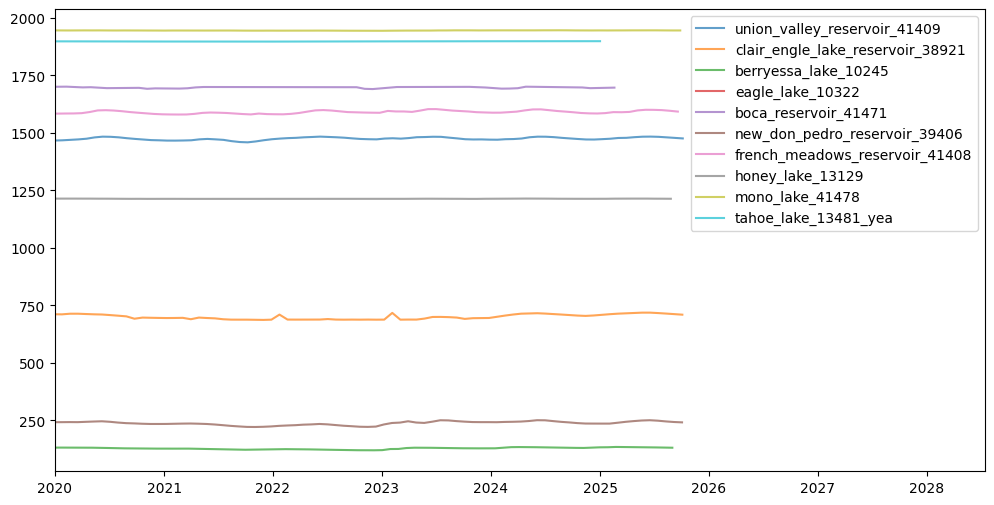

In [25]:
dahiti_lake_list = glob.glob(join(dahiti_path, '*.geojson'))

fig, ax = plt.subplots(1, figsize=(12,6))

for dahiti_lake in dahiti_lake_list[:10]:
    dahiti_df = gpd.read_file(dahiti_lake).drop(columns='geometry')
    dahiti_df['datetime'] = pd.to_datetime(dahiti_df['datetime'])
    dahiti_df = dahiti_df.set_index('datetime')
    lake_name = os.path.basename(dahiti_lake)[:-15]

    ax.plot(dahiti_df['water_level'], alpha=0.7, label=lake_name)

    ax.fill_between(dahiti_df['water_level'], dahiti_df['water_level']-dahiti_df['error'], dahiti_df['water_level']+dahiti_df['error'],
                    alpha=0.3)

ax.set_xlim(pd.to_datetime('2020-01-01'))
plt.legend();

## Generate a consolidated GeoJSON export for the platform

In [26]:
yearly_file_list = glob.glob(join(data_folder, 'dahiti', '*_yearly_avg.geojson'))

gdf_list = []
for file in yearly_file_list:
    gdf_list.append(gpd.read_file(file, parse_dates=['datetime']))

yearly_gdf = pd.concat(gdf_list)
yearly_gdf = yearly_gdf.loc[(yearly_gdf['datetime'] >= '2020-01-01'), ['datetime', 'water_level', 'geometry']]
yearly_gdf['datetime'] = yearly_gdf['datetime'].dt.year.astype(int)
yearly_gdf = yearly_gdf.rename(columns={'datetime': 'year', 'water_level': 'value'})

# limit precision to limit the filesize
yearly_gdf.geometry = yearly_gdf.simplify(0.01, preserve_topology=True)
yearly_gdf['value'] = yearly_gdf['value'].round(5)

In [27]:
# export
yearly_gdf.to_file(join(data_folder, 'DAHITI', 'waterlevels.json'), driver='GeoJSON')

## Generate Monthly averages per district for the platform
Not the best indicator, but it helps keeping it consistant with the other indicators

In [28]:
# load the AOI
aoi_gdf = gpd.read_file(aoi_path)

In [29]:
dahiti_file_list = glob.glob(join(dahiti_path, '*_dahiti.geojson'))

df_list = []
for file in dahiti_file_list:
    # export the ts
    gdf = gpd.read_file(file)

    # generate and export yearly gdf
    df = gdf[['datetime', 'water_level', 'error']].resample('1MS', on='datetime').mean().interpolate('time').reset_index()
    df = df.loc[df['datetime'] >= '2020-01-01', :]
    df = df.rename(columns={'datetime': 'month'})

    df[['district']] = gdf.iloc[[0]].sjoin(aoi_gdf[['district', 'geometry']]).loc[:, ['district']].values[0]
    
    df_list.append(df)

monthly_concat_df = pd.concat(df_list).reset_index(drop=True).rename(columns={'water_level':'mean'}).drop(columns='error')
monthly_concat_df['month'] = pd.to_datetime(monthly_concat_df['month'])
monthly_concat_df = monthly_concat_df.set_index('month').groupby([pd.Grouper(freq='1MS'), 'district']).mean().reset_index()

In [30]:
# export
monthly_concat_df.to_csv(join(data_folder, 'indicators', 'waterlevels.csv'))

<HR>

# TESTS